## Defining initial modules

In [1]:
import sys
sys.path.append("../")
sys.path.append("./")

In [2]:
import os
import pandas
import albumentations 
import matplotlib.pyplot as plt 
from PIL import Image
import numpy
import typing
import warnings
import torch 
from torch import optim

from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Defining data urls

In [3]:
# training images and masks

train_images_path = "../data/train/train/images_size_400/"
train_image_masks_path = "../data/train/train/masks_size_400/"

# train images and masks

first_exp_train_urls = [
    ("../data/train/train/images_size_400/", "../data/train/train/masks_size_400/"),
    ("../data/train/train/images_size_500/", "../data/train/train/masks_size_500/"),
    ("../data/train/train/images_size_600/", "../data/train/train/masks_size_600/"),
]

first_exp_validation_urls = [
    ("../data/train/_extra/images_size_500/", "../data/train/_extra/masks_size_500/"),
]


second_exp_train_urls = [
    ("../data/train/train/images_size_500/", "../data/train/train/masks_size_500/"),
    ("../data/train/train/images_size_600/", "../data/train/train/masks_size_600/"),
    ("../data/train/train/images_size_700/", "../data/train/train/masks_size_700/"),
]

second_exp_validation_urls = [
    ("../data/train/train/images_size_600/", "../data/train/train/masks_size_600/"),
]

## Loading small batch of images and masks for initial analysis

In [4]:
def load_files(file_path: str):
    """
    Function loads files from given 'file_path' source
    Args:
        - file_path - path, pointing to the files directory
        - number_of_files - respective number of files to load
    """
    batch = []
    for path in os.listdir(file_path):
        try:
            full_url = os.path.join(file_path, path)
            ext = path.split(".")[-1]
            if ext in ('jpeg', 'png', 'jpg'):
                batch.append(full_url)
                
        except(FileNotFoundError):
            print('file not found: %s' % full_url)
    return batch

In [5]:
def load_experiment_data(urls: typing.Tuple[str]):
    """
    Function loads data for experiment
    
    urls: (img_url, mask_url) - list of tuples, containing
    corresponding images and masks with different resolutions
    """
    imgs, masks = [], []
    for img_path, mask_path in urls:
    
        imgs = load_files(file_path=train_images_path)
        masks = load_files(file_path=train_image_masks_path)

        imgs.extend(imgs)
        masks.extend(masks)
    return imgs, masks

# Loading training and validation sets for first experiment

In [6]:
%%time

f_train_imgs, f_train_masks = load_experiment_data(first_exp_train_urls)
f_validation_imgs, f_validation_masks = load_experiment_data(first_exp_validation_urls)

CPU times: user 50.9 ms, sys: 11.7 ms, total: 62.6 ms
Wall time: 65.7 ms


In [7]:
first_exp_train_info = pandas.DataFrame(
    {
        'image': f_train_imgs,
        'mask': f_train_masks
    }
)

first_exp_validation_info = pandas.DataFrame(
    {
        'image': f_validation_imgs,
        'mask': f_validation_masks
    }
)

# Loading training and validation sets for second experiment

In [8]:
s_train_imgs, s_train_masks = load_experiment_data(first_exp_train_urls)
s_validation_imgs, s_validation_masks = load_experiment_data(first_exp_validation_urls)

In [9]:
%%time

second_exp_train_info = pandas.DataFrame(
    {
        'image': s_train_imgs,
        'mask': s_train_masks
    }
)

second_exp_validation_info = pandas.DataFrame(
    {
        'image': s_validation_imgs,
        'mask': s_validation_masks
    }
)

CPU times: user 4.37 ms, sys: 105 µs, total: 4.48 ms
Wall time: 3.64 ms


# Visualizing images and masks

In [10]:
import typing

def visualize_set_of_images(imgs: typing.List, masks: typing.List):
    """
    Function visualizes image for a given
    set of data
    """
    _, ax = plt.subplots(ncols=2, nrows=5)
    plt.figure(figsize=(30, 30))

    for idx in range(5):
        
        img = Image.open(imgs[idx])
        mask = Image.open(masks[idx])
        
        ax[idx,0].imshow(img)
        ax[idx,1].imshow(mask, cmap='gray')

## Visualizing images and masks for training set (first experiment)

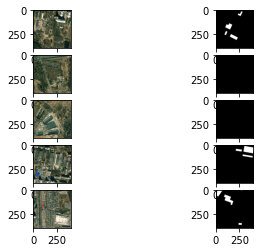

<Figure size 2160x2160 with 0 Axes>

In [11]:
visualize_set_of_images(f_train_imgs, f_train_masks)

## Visualizing images and masks for validation set (first experiment)

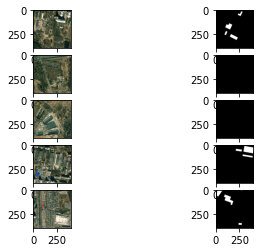

<Figure size 2160x2160 with 0 Axes>

In [12]:
visualize_set_of_images(f_validation_imgs, f_validation_masks)

## Defining Augmentation Pipeline

In [13]:
train_color_transformations = albumentations.Compose(
    [
        albumentations.OneOf([
            albumentations.ColorJitter(
                brightness=0.15,
                hue=0.15,
                saturation=0.15
            ),
            albumentations.FancyPCA()
        ])
    ]
)

## Defining Datasets for first experiment

In [14]:
from dataset.dataset import SegmentationDataset 

f_train_dataset = SegmentationDataset(
    imgs=first_exp_train_info['image'].tolist(),
    masks=first_exp_train_info['mask'].tolist(),
    color_transformations=train_color_transformations
)

f_validation_dataset = SegmentationDataset(
    imgs=first_exp_validation_info['image'].tolist(),
    masks=first_exp_validation_info['mask'].tolist(),
)

## Defining datasets for second experiment

In [15]:
s_train_dataset = SegmentationDataset(
    imgs=second_exp_train_info['image'].tolist(),
    masks=second_exp_train_info['mask'].tolist(),
    color_transformations=train_color_transformations
)

s_validation_dataset = SegmentationDataset(
    imgs=second_exp_validation_info['image'].tolist(),
    masks=second_exp_validation_info['mask'].tolist()
)

# Beginning of experiments.

### Defining loss functions and evaluation metrics for experiments

In [16]:
from losses.losses import DiceLoss, FocalLoss, ComboLoss

focal_gamma = 2

dice_loss = DiceLoss()
focal_loss = FocalLoss(gamma=focal_gamma)

combo_loss = ComboLoss(
    dice_prop=0.4, 
    focal_prop=0.6, 
    focal_gamma=focal_gamma
)

### Defining network for experiment

In [17]:
from networks import unet
network = unet.UNet()

### Defining optimizers and learning rate 

In [18]:
learning_rate = 3e-6
adam_opt = optim.Adam(params=network.parameters(), lr=learning_rate, weight_decay=1e-5)
sgd_opt = optim.SGD(params=network.parameters(), lr=learning_rate)

### Defining lr scheduling techniques

In [19]:
from torch.optim import lr_scheduler

reduction_gamma = 0.0001
step_size = 5
patience_epochs = 5

adam_step_scheduler = lr_scheduler.StepLR(
    optimizer=adam_opt,
    step_size=step_size, 
    gamma=reduction_gamma
)

sgd_step_scheduler = lr_scheduler.StepLR(
    optimizer=sgd_opt,
    step_size=step_size, 
    gamma=reduction_gamma
)

adam_plateau_scheduler = lr_scheduler.ReduceLROnPlateau(
    adam_opt, mode='min', 
    factor=0.1,
    patience=patience_epochs, 
    min_lr=learning_rate
)

sgd_plateau_scheduler = lr_scheduler.ReduceLROnPlateau(
    sgd_opt, mode='min', 
    factor=0.1,
    patience=patience_epochs, 
    min_lr=learning_rate
)

# Defining early stopping dataset for regularization of the Network

In [20]:
total_objs = round(len(f_validation_dataset) * 0.10)

_, early_indices = train_test_split(
    numpy.arange(len(f_validation_dataset)), 
    test_size=total_objs
)

early_stopping_imgs = first_exp_validation_info['image'][early_indices].tolist()
early_stopping_masks = first_exp_validation_info['mask'][early_indices].tolist()

early_stopping_dataset = SegmentationDataset(
    imgs=early_stopping_imgs,
    masks=early_stopping_masks
)

### Importing network trainer

In [21]:
from network_trainer.network_trainer import NetworkTrainer

In [34]:
trainer = NetworkTrainer(
    network=network,
    optimizer=adam_opt,
    lr_scheduler=adam_step_scheduler,
    loss_function=focal_loss,
    train_device='cuda',
    max_image_height=5000,
    max_image_width=5000,
    max_epochs=20,
    batch_size=32,
)

In [ ]:
%%time
train_loss, train_history = trainer.train(f_train_dataset)

100%|██████████| 278/278 [03:25<00:00,  1.36it/s]


0 epochs passed


100%|██████████| 278/278 [03:23<00:00,  1.36it/s]


1 epochs passed


100%|██████████| 278/278 [03:23<00:00,  1.36it/s]


2 epochs passed


100%|██████████| 278/278 [03:25<00:00,  1.36it/s]


3 epochs passed


100%|██████████| 278/278 [03:24<00:00,  1.36it/s]


4 epochs passed


100%|██████████| 278/278 [03:24<00:00,  1.36it/s]


5 epochs passed


100%|██████████| 278/278 [03:25<00:00,  1.35it/s]


6 epochs passed


100%|██████████| 278/278 [03:22<00:00,  1.37it/s]


7 epochs passed


100%|██████████| 278/278 [03:23<00:00,  1.37it/s]


8 epochs passed


100%|██████████| 278/278 [03:25<00:00,  1.35it/s]


9 epochs passed


 15%|█▍        | 41/278 [00:28<02:56,  1.34it/s]

In [ ]:
print('training loss for first trainer: %s' % str(f_train_loss))

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(numpy.arange(len((f_train_history))), f_train_history)
plt.title("Training loss for the first experiment")

# Evaluating network on validation set

In [ ]:
%%time
f_eval_metric = trainer.evaluate(f_validation_dataset)

In [ ]:
import cv2

fg, ax = plt.subplots(ncols=2, nrows=5, figsize=(20, 30))
for idx in range(5):
    img_url, mask_url = f_validation_dataset.imgs[0], f_validation_dataset.masks[0]
    mask = cv2.imread(mask_url, cv2.IMREAD_UNCHANGED)
    predicted_mask = trainer.predict([img_url])[0]
    ax[idx, 0].imshow(predicted_mask, cmap='gray')
    ax[idx, 1].imshow(mask, cmap='gray')

In [ ]:
print('evaluation metric f1-score for first trainer: %s' % str(f_eval_metric))

# Loading testing data

In [ ]:
test_images = load_files("../test_data/")

In [ ]:
import cv2
non_test_files = [cv2.imread(img_url, cv2.IMREAD_UNCHANGED) for img_url in test_images]

In [ ]:
predicted_masks = trainer.predict(test_images)

In [ ]:
for mask in predicted_masks:
    plt.imshow(mask)

## Converting model to ONNX Format

In [ ]:
model_path = "../final_model/network.onnx"
trainer.save_network(model_path, best_input)